In [1]:
import math
import numpy as np
import scipy as sp
import torch
import pennylane as qml

import matplotlib.pyplot as plt
plt.style.use('./pptnqfe.mplstyle')

from qulearn.hat_basis import HatBasis
from qulearn.qlayer import HatBasisQFE

# Section 2

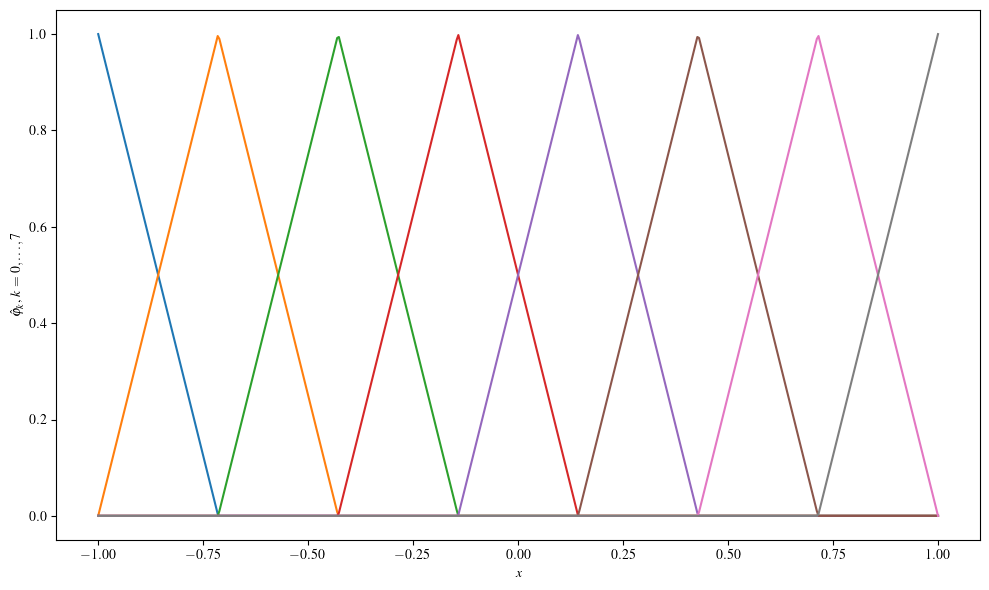

In [2]:
num_qubits = 3
num_nodes = 2**num_qubits
a = -1.0
b = 1.0
hat_basis = HatBasis(a=a, b=b, num_nodes=num_nodes)

num_pnts = 500
xvals = torch.linspace(-1.0, 1.0, num_pnts)
basis_vectors = hat_basis.eval_basis_vector(xvals)

plt.figure(figsize=(10, 6))
for i in range(basis_vectors.shape[1]):
    plt.plot(xvals, basis_vectors[:, i])
plt.xlabel('$x$')
plt.ylabel('$\hat{\\varphi}_k$, $k=0,\ldots,7$')
plt.tight_layout()
plt.savefig('./figures/hat_basis.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Section 5.1
Important to note: pennylane is bad at preparing conditional circuits based on a circuit
as input.
We are forced to use unitaries (instead of circuits) and pennylane
functions that extract unitaries based on circuits (qml.matrix).
This is not only not scalable, pennylane also
sometimes returns unitaries that are not the same
as the circuit that was used for preparation -- up to a phase.
Also, take care of the wire_order when using qml.matrix.

Therefore, sometimes the code for this section will produce incorrect
results due to a sign flip. This is a purely pennylane issue that
works fine with, e.g., qiskit (see arXiv:2211.14064).

In [3]:
num_qubits = 5 # number of qubits for ansatz
num_layers = 3 # number of variational layers for ansatz

@qml.qnode(qml.device('default.qubit', wires=range(num_qubits+1)), interface="torch")
def innerp_circuit(U1, U2):
    qml.Hadamard(0)
    qml.ControlledQubitUnitary(U1, control_wires=[0], wires=range(1, num_qubits+1))
    qml.PauliX(0)
    qml.ControlledQubitUnitary(U2, control_wires=[0], wires=range(1, num_qubits+1))
    qml.Hadamard(0)
    
    return qml.expval(qml.PauliZ(0))

def Uf(num_qubits):
    qml.PauliX(0)
    for idx in range(num_qubits):
        qml.Hadamard(wires=idx)

def psi(initlayer_weights, weights, num_qubits, num_layers):
    wires = list(range(num_qubits))
    for i, q in enumerate(wires):
        qml.RY(initlayer_weights[i], q)
    
    for layer in range(num_layers):
        for i in range(0, len(wires) - 1, 2):
            qml.CZ(wires=[wires[i], wires[i + 1]])
            qml.RY(
                weights[layer, i],
                wires[i],
            )
            qml.RY(
                weights[layer, i + 1],
                wires[i + 1],
            )

        offset = int(num_qubits / 2) * 2
        for i in range(1, len(wires) - 1, 2):
            qml.CZ(wires=[wires[i], wires[i + 1]])
            qml.RY(
                weights[layer, offset + i - 1],
                wires[i],
            )
            qml.RY(
                weights[layer, offset + i],
                wires[i + 1],
            )
            
@qml.qnode(qml.device('default.qubit', wires=range(num_qubits)), interface="torch")
def Aeven(initlayer_weights, weights, num_qubits, num_layers):
    psi(initlayer_weights, weights, num_qubits, num_layers)
    qml.Hadamard(num_qubits-1)
    return qml.expval(qml.PauliZ(num_qubits-1))

@qml.qnode(qml.device('default.qubit', wires=range(num_qubits)), interface="torch")
def Aodd_IX(initlayer_weights, weights, num_qubits, num_layers):
    psi(initlayer_weights, weights, num_qubits, num_layers)
    for idx in range(1, num_qubits):
        ctrl_wires = list(range(idx, num_qubits))
        qml.ctrl(qml.PauliX, control=ctrl_wires)(idx-1)
        
    qml.PauliX(num_qubits-1)
    qml.Hadamard(num_qubits-1)
    return qml.expval(qml.PauliZ(num_qubits-1))

@qml.qnode(qml.device('default.qubit', wires=range(num_qubits)), interface="torch")
def Aodd_I0X(initlayer_weights, weights, num_qubits, num_layers):
    psi(initlayer_weights, weights, num_qubits, num_layers)
    for idx in range(1, num_qubits):
        ctrl_wires = list(range(idx, num_qubits))
        qml.ctrl(qml.PauliX, control=ctrl_wires)(idx-1)
        
    qml.PauliX(num_qubits-1)
    qml.Hadamard(num_qubits-1)
    I0 = qml.Projector(basis_state=[0]*(num_qubits-1), wires=list(range(0, num_qubits-1)))   
    return qml.expval(I0 @ qml.PauliZ(num_qubits-1))

def cost_poisson(initlayer_weights, weights):
    Uf_mat = qml.matrix(Uf, wire_order=list(range(num_qubits)))(num_qubits)
    Upsi_mat = qml.matrix(psi, wire_order=list(range(num_qubits)))(initlayer_weights, weights, num_qubits, num_layers)
    innerp = innerp_circuit(Uf_mat, Upsi_mat)
    
    even = Aeven(initlayer_weights, weights, num_qubits, num_layers)
    odd_IX = Aodd_IX(initlayer_weights, weights, num_qubits, num_layers)
    odd_I0X = Aodd_I0X(initlayer_weights, weights, num_qubits, num_layers)
 
    op = 2.0-even-odd_IX+odd_I0X
    cost = -0.5*innerp**2/op
    
    return cost
    
initlayer_weights = torch.randn(num_qubits, requires_grad=True)
weights = torch.randn(num_layers, 2*(num_qubits-1), requires_grad=True)

In [4]:
steps = 100
opt = torch.optim.Adam([initlayer_weights, weights], lr = 0.1)

def closure():
    opt.zero_grad()
    loss = cost_poisson(initlayer_weights, weights)
    loss.backward()
    return loss

for it in range(steps):
    opt.step(closure)
    cost = cost_poisson(initlayer_weights, weights)
    print("Step {:3d}       cost = {:9.7f}".format(it, cost))

Step   0       cost = -0.0180615
Step   1       cost = -0.0520769
Step   2       cost = -0.1153291
Step   3       cost = -0.2334422
Step   4       cost = -0.4309922
Step   5       cost = -0.7912761
Step   6       cost = -1.7373658
Step   7       cost = -2.1369514
Step   8       cost = -2.8749847
Step   9       cost = -3.0365750
Step  10       cost = -2.9486064
Step  11       cost = -3.7784953
Step  12       cost = -4.3949427
Step  13       cost = -4.1519136
Step  14       cost = -4.5898826
Step  15       cost = -5.1697779
Step  16       cost = -5.1752569
Step  17       cost = -5.2922859
Step  18       cost = -5.8515482
Step  19       cost = -6.2679232
Step  20       cost = -6.4524167
Step  21       cost = -7.2102033
Step  22       cost = -7.1957818
Step  23       cost = -7.2858940
Step  24       cost = -7.2842176
Step  25       cost = -7.4880126
Step  26       cost = -7.9210626
Step  27       cost = -7.9747296
Step  28       cost = -8.8202083
Step  29       cost = -9.1143316
Step  30  

The code below sometimes returns a solution with flipped sign, as explained above.

In [5]:
# Watch out for possibly flipped sign
@qml.qnode(qml.device('default.qubit', wires=range(num_qubits)), interface="torch")
def extract_psi(initlayer_weights, weights, num_qubits, num_layers):
    psi(initlayer_weights, weights, num_qubits, num_layers)
    return qml.state()

psi_vec = extract_psi(initlayer_weights, weights, num_qubits, num_layers)

In [6]:
def eval_basis(x, Upsi, num_qubits):
    h = 2.0/(2**num_qubits+1)
    a = -1.0+h
    b = 1.0-h
    num_nodes = 2**num_qubits
    basis = HatBasis(a=a, b=b, num_nodes=num_nodes)
    qfe = HatBasisQFE(wires=num_qubits, basis=basis, sqrt=False, normalize=True)
    norm = qfe.compute_norm(x)
    Ubasis = qml.matrix(qfe.circuit, wire_order=list(range(num_qubits)))(x)
    result = norm*innerp_circuit(Ubasis, Upsi)
    
    return result

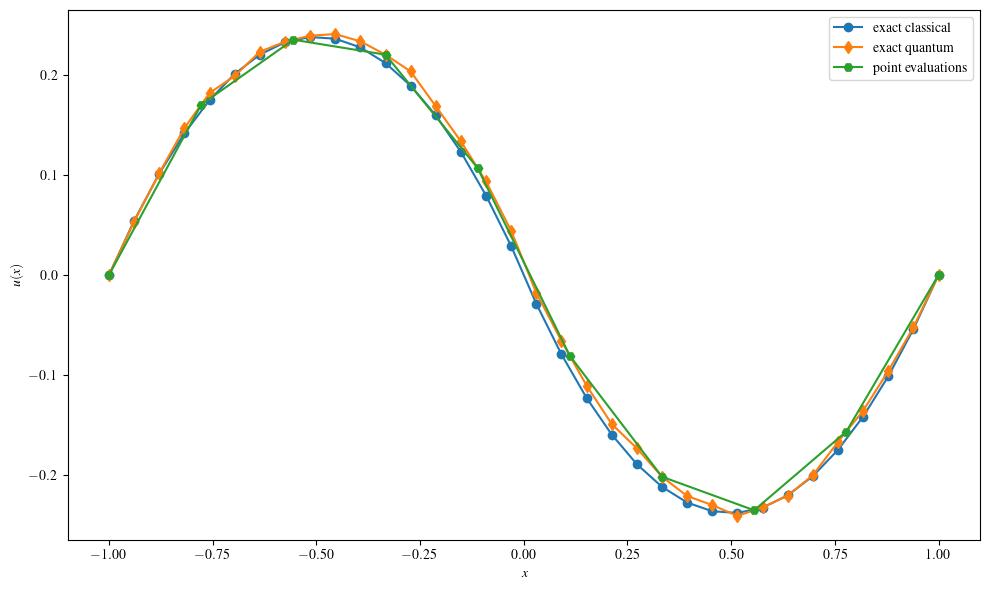

In [7]:
N = 2**num_qubits       
diagonals = [[-1]*(N-1), [2]*N, [-1]*(N-1)]
A = sp.sparse.diags(diagonals, offsets=[-1, 0, 1]).toarray()
b = np.ones(N)
b[int(N/2):] *= -1
b /= math.sqrt(N)                                                                    

u = sp.linalg.solve(A, b)
u /= np.linalg.norm(u)
x_k = np.linspace(-1, 1, N+2)
ub = np.zeros(N+2)
ub[1:-1] = u
ubq = torch.zeros(N+2)
ubq[1:-1] = np.real(psi_vec)

plt.figure(figsize=(10, 6))
plt.plot(x_k, ub, 'o-', label="exact classical")
plt.plot(x_k, ubq.detach().numpy(), 'd-', label="exact quantum")

xk = torch.linspace(-1.0, 1.0, steps=10, dtype=torch.float64).reshape(-1, 1)
yk = torch.zeros_like(xk)
Upsi = qml.matrix(psi, wire_order=list(range(num_qubits)))(initlayer_weights, weights, num_qubits, num_layers)
for i, x in enumerate(xk):
    yk[i] = eval_basis(x, Upsi, num_qubits)
    
plt.plot(xk, yk.detach().numpy(), 'H-', label="point evaluations")
plt.xlabel('$x$')
plt.ylabel('$u(x)$')
plt.legend()
plt.tight_layout()
plt.savefig('./figures/poisson.pdf', format='pdf', bbox_inches='tight')
plt.show()